# Building Agents with LangGraph

## Learning Objectives

1. Understand Graph State: Learn how to define and manage the state within a LangGraph application.
2. Build Simple Graphs: Discover how to construct and run basic cyclical and acyclical graphs.
3. Implement Tool Use: Explore how to integrate tools (function calling) within your graphs for more complex tasks.
4. Incorporate Human-in-the-Loop: Learn how to add human review and intervention points within your graph execution.



## Overview

In this notebook, you'll dive into LangGraph, a library designed to help you build robust, stateful, and agentic applications with Large Language Models (LLMs). LangGraph extends the LangChain ecosystem, allowing you to create cyclical graphs, which are essential for many agent-like behaviors where you might need to loop, re-plan, or conditionally execute steps.

Unlike traditional LangChain chains, which are typically directed acyclic graphs (DAGs), LangGraph enables you to define more complex flows that can revisit nodes and manage state explicitly across these steps. This is crucial for building sophisticated applications like AI agents that can plan, execute actions, observe results, and adapt their behavior.

This notebook will guide you through the fundamental concepts of LangGraph, from understanding its core component—the graph state—to building simple graphs, integrating tools for enhanced capabilities, and incorporating human oversight into your LLM applications.

For more information, check out the official [LangGraph documentation](https://langchain-ai.github.io/langgraph/).

## The Simplest Graph

Let's build a simple graph with 3 nodes and one conditional edge. 

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

### State

The [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) is a critical concept in LangGraph. It represents the single, unified object that is passed around between all the nodes (steps) in your graph. Think of it as the memory or working context of your application. As your graph executes, each node can read from and write to this state, allowing information to be accumulated, modified, and used to make decisions throughout the workflow.


State enables:
* Persistence of Information: It allows data generated in one step (e.g., an LLM response, a tool output) to be available to subsequent steps.
* Shared Memory: All nodes in the graph operate on the same state object (though they might only care about specific parts of it). This ensures consistency.
* Decision Making: The current state can be used by conditional edges to route the flow of execution within the graph. For example, an agent might decide which tool to use next based on the current state of the problem.
* Cyclical Flows: In graphs that loop or revisit steps (a core strength of LangGraph), the state ensures that each iteration builds upon the last, rather than starting from scratch.


### Defining the State Schema
The structure of your State, its "schema," defines what kind of information your graph will track. This schema is then used as the input type for all nodes and the output type for most nodes within your graph. LangGraph is flexible in how you define this schema. For this lab, we will use Pydantic's BaseModel to define our graph's state, which provides a good balance of structure, validation, and ease of use. LangGraph State also supports use of TypedDict objects.

In [1]:
from pydantic import BaseModel


class State(BaseModel):
    graph_state: str

### Nodes

In LangGraph, [Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are the fundamental units of computation. They represent the individual steps, actions, or processing logic within your graph. Each node is responsible for performing a specific task, such as calling an LLM, executing a tool, processing data, or even waiting for human input.

##### Nodes are Python Functions
One of the elegant aspects of LangGraph is its simplicity in defining nodes: nodes are just Python functions. This design choice offers several advantages:

Every function that you designate as a node in your LangGraph graph receives the current State object as its first positional argument. This State object is an instance of the schema you defined earlier (e.g., your Pydantic BaseModel). In our simple graph, the nodes will update the State's `graph_state` field.

In [2]:
def node_1(state: State):
    print("---Node 1---")
    return {"graph_state": state.graph_state + " I am"}


def node_2(state: State):
    print("---Node 2---")
    return {"graph_state": state.graph_state + " happy!"}


def node_3(state: State):
    print("---Node 3---")
    return {"graph_state": state.graph_state + " sad!"}

With our node functions defined, the next step is to construct the actual graph. This is done using the StateGraph class.

When we instantiate StateGraph, we pass our defined State schema (e.g., our Pydantic BaseModel or TypedDict) to its constructor. This tells the graph what the structure of its internal state will look like, ensuring that all nodes and edges operate on a consistent data model.

Once the graph object is created (here, builder), we then register our Python functions as nodes within this graph using the add_node() method. Each call to add_node() takes two main arguments:

1. A unique string name for the node (e.g., "node_1"). This name is used to refer to the node when defining edges and execution flow.
2. The Python function itself that implements the node's logic (e.g., node_1).

In [3]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

### Edges

Now that we have nodes (our functions that do the work) and a defined state (the data that flows through), we need to connect them. Edges in LangGraph define the pathways between nodes, dictating the sequence of operations and the overall logic of your application. They determine which node executes after another.

LangGraph provides a few ways to define these connections, primarily through normal edges for fixed transitions and conditional edges for dynamic routing.

#### The START and END Points
Before diving into specific edge types, it's important to know two special keywords:

* START: This is a special identifier used to define the entry point of your graph. You'll typically add an edge from START to your initial processing node.
* END: This is another special identifier. When the graph transitions to END, it signifies that a particular path of execution has completed. A graph can have multiple paths leading to END.


#### Normal Edges
A [Normal Edge](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) creates a straightforward, unconditional link from one node to another. If node A has a normal edge to node B, then every time node A finishes executing, node B will be the next one to run.

You create a normal edge using the `builder.add_edge(source_node_name: str, destination_node_name: str)` method.

For instance, after a specific processing step, you might always want to save the results, or if a branch leads to a final action, you'd connect that action's node to END.

#### Conditional Edges: Dynamic Routing Based on State
[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) allow you to route the execution flow based on the current State of your graph. Instead of a fixed next step, a function (the "condition") is evaluated, and its output determines which node(s) to visit next.

Conditional edges are implemented as follows:

* A Condition Function: You write a Python function that accepts the current State object as its argument.
* Decision Logic: Inside this function, you implement logic that inspects the state and decides where the graph should go next.
* Return Value: The function typically returns a string (or a list of strings) which is the name of the next node(s) to execute.

You add conditional edges using the `builder.add_conditional_edges(source_node_name: str, condition_function: Callable, path_map: Optional[dict] = None)` method.

* `source_node_name`: The node from which the conditional branching originates.
* `condition_function`: Your Python function that takes the state and returns the name of the next node.
* `path_map` (Optional): If your condition function returns a value that isn't directly a node name (e.g., it returns 'category_a' or 'category_b'), you can provide a dictionary mapping these return values to actual node names (e.g., {"category_a": "node_for_a", "category_b": "node_for_b"}). However, as you'll see in the example below, if your condition function directly returns the string name of the next node, you don't need a complex path_map.

In the following code, we'll define a `decide_mood` function that looks at the state (though in this simple example, it will just make a random choice for illustrative purposes) and returns the name of the next node to visit. This function will be used to conditionally route from node_1 to either node_2 or node_3.

In [4]:
import random
from typing import Literal


def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state.graph_state

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

In [5]:
# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

### Compilation
Before we can run our graph, we need to call the `.compile()` method on our StateGraph builder instance. This step finalizes the graph structure, verifies its integrity, and returns an executable LangChain Runnable.

We can also visualize our graph! Note that conditional edges are displayed with dotted lines.

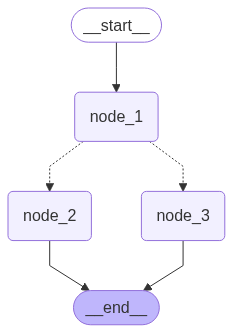

In [6]:
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

Once we've defined our State, added our Nodes (the functions that do the work), connected them with Edges (defining the flow), and compiled it, our graph blueprint is complete. The next step is to run it.

The compiled LangGraph graph adheres to the [LangChain Runnable](https://python.langchain.com/docs/concepts/runnables/) protocol. This is a standard interface used across the LangChain ecosystem, providing a consistent way to interact with different components. If you're familiar with LangChain, methods like invoke(), stream(), batch(), and their asynchronous counterparts (ainvoke(), etc.) will feel natural. This standardization makes it easier to integrate LangGraph into larger LangChain applications.

##### Executing the Graph
For a single, synchronous execution of the graph, we can use the `invoke()` method. The `invoke()` method takes a single argument: a dictionary that defines the **initial state** of the graph. The keys in this dictionary must correspond to the fields you defined in your State schema. For instance, if your State object has a field named graph_state, your input to invoke would look like {"graph_state": "initial value for graph_state"}.

##### Execution Process

* Initialization: When `invoke()` is called, the provided input dictionary populates the graph's initial state.
* Starting Point: Execution begins at the special START node you defined when adding edges.
* Node Execution & State Updates: The graph then transitions to the first actual node (e.g., node_1 in our example). This node function executes, receiving the current state. It performs its logic and returns a dictionary of updates. These updates are then applied to the graph's state (by default, overriding the values of the returned keys).
* Edge Traversal: After a node completes, the graph consults its edges to determine the next step:
* * If there's a normal edge, it proceeds to the specified next node.
* * If there's a conditional edge (like the one from node_1 using our decide_mood function), the condition function is called with the current state. The return value of this function dictates which node to visit next (e.g., node_2 or node_3 based on our 50/50 logic).
* Continuation: This process of node execution, state update, and edge traversal continues. The state evolves with each step, carrying information and context through the graph.
* Termination: The execution continues until a path leads to the special END node. Once END is reached, that particular execution path of the graph concludes.

The `invoke()` method returns the **final state** of the graph after it has reached an END node. This final state will contain all the accumulated and modified data from the sequence of executed nodes.

In [7]:
graph.invoke({"graph_state": ""})

---Node 1---
---Node 2---


{'graph_state': ' I am happy!'}

## Simple Agent with Function Calling tool

In many real-world applications, an LLM needs to:
* Access up-to-date information (e.g., search the web, query a database).
* Perform precise calculations (like the mathematical operations we'll explore).
* Interact with other APIs or external systems.

Function Calling (or Tool Use) allows an LLM to indicate when it needs to invoke such external capabilities. Within a LangGraph structure, we can:
* Have a node (often an LLM) that decides if and which tool to call based on the current state and task.
* Execute that tool (which could be another node or an external Python function).
* Feed the tool's output back into the graph's state, allowing subsequent nodes (perhaps the LLM again) to process these results and continue the task.

This section will demonstrate how to integrate tool-calling functionality, transforming our graph into a simple agent capable of deciding when to use a tool and incorporating its results into its workflow. This mirrors how, in more basic function calling setups, a model might choose to call a tool and then process a ToolMessage containing the outcome.
 
![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [8]:
from langchain_google_vertexai import ChatVertexAI, VertexAI, VertexAIEmbeddings

llm = ChatVertexAI(model="gemini-2.0-flash")

Define the functions/tools as Python functions.

In [9]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

#### Defining the assistant node

Here is what we need:
* State with MessagesState: We use MessagesState to keep track of our conversation. It holds a list of messages (human, AI, tool) under the messages key and new messages are appended, maintaining history. Our assistant node, as defined, will leverage this.

* Assistant Node: This node houses our LLM (llm_with_tools), which is equipped to call functions. It takes the current MessagesState, includes the system prompt, and generates a response. This response might be a direct answer or a request to use a tool.

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

#### Agentic Loop for Tool Use
To make tools functional, we'll create a graph with a loop:

1. The assistant runs.
2. A conditional edge then checks the assistant's output.
* If it's a tool call, flow goes to a Tool Executor node (which we'll define to run the actual tool function).
* If it's a direct answer, flow goes to END.
3. After the Tool Executor runs and adds the tool's result (as a ToolMessage) to the state, the graph routes back to the assistant.

This loop (assistant -> conditional check -> Tool Executor -> assistant) allows the agent to call a tool, see its output, and then decide on the next action—either calling another tool or providing a final response. The process stops when the assistant generates a response that isn't a tool call.

In [11]:
from IPython.display import Image, display
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

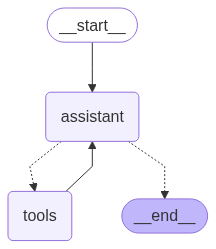

In [12]:
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3.")}

# thread = {"configurable": {"thread_id": "1"}}

for event in react_graph.stream(initial_input, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (09ff1e2c-a944-4335-aeea-977013e740d1)
 Call ID: 09ff1e2c-a944-4335-aeea-977013e740d1
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Breakpoint and Human-in-the-loop

While automated agents are powerful, sometimes we need points for human oversight or intervention. LangGraph facilitates this through breakpoints and checkpointing.

By setting breakpoints, we can pause the graph's execution just before certain nodes run. This pause allows a human to review the current state, potentially modify it, or validate the agent's next intended action before allowing it to proceed.

To enable this, we use:

* Checkpointers (like MemorySaver): These save the graph's state at various points, including when it's interrupted. This ensures that we can resume execution later.
* The interrupt_before argument during graph compilation. This tells LangGraph which node(s) should trigger an interruption before they execute.

The following code will demonstrate how to compile our graph with a checkpointer and set an interruption point, allowing us to inspect the flow and simulate a human-in-the-loop scenario.

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

react_graph = builder.compile(checkpointer=memory, interrupt_before=["tools"])

thread = {"configurable": {"thread_id": "1"}}

for event in react_graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (24b61834-1bb1-420e-9399-4ebc52809692)
 Call ID: 24b61834-1bb1-420e-9399-4ebc52809692
  Args:
    a: 2.0
    b: 3.0


In the preceding step, we compiled our graph using MemorySaver for checkpointing and specified `interrupt_before=["tools"]`. This tells the graph to pause execution just before the "tools" node (our tool executor) would normally run. We also initiated a stream using thread_id: "1". During that stream, the graph processed the input and, upon reaching the "tools" node, would have paused, saving its current state associated with thread_id: "1" into our memory checkpointer.

Now, we'll demonstrate a more explicit human-in-the-loop scenario. We will:

* Start a new, independent execution stream with a fresh thread_id: "2". This allows us to manage multiple graph executions and their states separately.
* Let this new stream run until it hits the same `interrupt_before=["tools"]` breakpoint.
* At this pause, we will then simulate a human making a decision by prompting for input.
* Based on this input, we will either resume the graph's execution for thread_id: "2" from where it left off (if approved) or halt further processing for this thread.

This illustrates how you can intervene in an agent's workflow, inspect its intentions, and guide its actions.

In [15]:
# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in react_graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":

    # If approved, continue the graph execution
    for event in react_graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()

else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (795ac714-ce63-4627-8da5-29a9fe7542fc)
 Call ID: 795ac714-ce63-4627-8da5-29a9fe7542fc
  Args:
    b: 3.0
    a: 2.0


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  multiply (795ac714-ce63-4627-8da5-29a9fe7542fc)
 Call ID: 795ac714-ce63-4627-8da5-29a9fe7542fc
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


---
## Build a complex Essays writing agent

This section demonstrates how to build a LangGraph-powered AI agent to generate, revise, and critique essays using Gemini. The LangGraph code was adapted from the awesome DeepLearning.AI course on AI Agents in LangGraph.

By defining a structured state flow with nodes such as "Planner," "Research Plan," "Generate," "Reflect," and "Research Critique," the system iteratively creates an essay on a given topic, incorporates feedback, and provides research-backed insights.

The agent will perform the following steps:
1.  **Plan:** Create an initial outline for the essay based on the given topic.
2.  **Research Plan:** Generate search queries based on the topic to gather initial information.
3.  **Generate:** Write a draft of the essay using the plan and researched content.
4.  **Reflect:** Critique the generated draft, identifying areas for improvement.
5.  **Research Critique:** Generate new search queries based on the critique to find information for revisions.
6.  **Loop:** The generation, reflection, and research critique steps can loop a specified number of times to iteratively improve the essay.

<img width="1084" alt="image" src="https://camo.githubusercontent.com/f39ea212d055cb3982e931286d62cd08ec812881f4257ff1a4fd0755fc9cb628/68747470733a2f2f6769746875622e636f6d2f476f6f676c65436c6f7564506c6174666f726d2f67656e657261746976652d61692f626c6f622f6d61696e2f776f726b73686f70732f61692d6167656e74732f332d6c616e6767726170682d65737361792e706e673f7261773d31">

The workflow enables automated essay generation with revision controls, making it ideal for structured writing tasks or educational use cases. Additionally, the notebook uses external search tools to gather and integrate real-time information into the essay content.



In [16]:
import os
from typing import List, Optional

from IPython.display import Markdown, display

### Configure Tavily
Get an API key for [Tavily](https://tavily.com/), a web search API for Generative AI models.
Tavily will be used by our agent to perform research and gather up-to-date information from the web to incorporate into the essay.

In [19]:
from tavily import TavilyClient

os.environ["TAVILY_API_KEY"] = "YOUR API KEY"
tavily = TavilyClient()

### Initialize agent memory, agent state, and schema for search queries

Before defining the agent's nodes and graph structure, we need to set up the foundational components:
* **Agent State (`AgentState`):** This pydantic `BaseModel` will hold all the information that flows through our graph. It includes the task, essay plan, draft, critique, researched content, revision number, and maximum allowed revisions. Each node in the graph will read from and write to this state.
* **Search Queries Schema (`Queries`):** This Pydantic `BaseModel` defines the expected structure for the search queries that our research nodes will generate. Using a schema helps ensure that the LLM produces queries in a usable format.

In [20]:
class AgentState(BaseModel):
    task: str
    plan: Optional[str] = ""
    draft: Optional[str] = ""
    critique: Optional[str] = ""
    content: List[str]
    revision_number: int
    max_revisions: int


class Queries(BaseModel):
    """Variants of query to search for"""

    queries: list[str]

### Define prompt templates for each stage

Clear and effective prompts are essential for guiding the LLM at each stage of the essay writing process. We define specific prompt templates for:
* **PLAN_PROMPT:** Instructs the LLM to act as an expert writer and create a high-level outline for the essay.
* **RESEARCH_PLAN_PROMPT:** Guides the LLM to act as a researcher and generate search queries to gather initial information for the essay.
* **WRITER_PROMPT:** Instructs the LLM to act as an essay assistant, write a 3-page essay based on the plan and research, and revise based on critique. It also specifies Markdown formatting.
* **REFLECTION_PROMPT:** Tells the LLM to act as a teacher grading the essay, providing critique and detailed recommendations.
* **RESEARCH_CRITIQUE_PROMPT:** Guides the LLM to generate search queries based on the essay draft and the critique to find information for revisions.

In [21]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic. Give an outline of the essay along with any
relevant notes or instructions for the sections."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can
be used when writing the following essay. Generate a list of search queries that will gather
any relevant information. Only generate 3 queries max."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 3-pages essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Use Markdown formatting to specify a title and section headers for each paragraph.
Utilize all of the information below as needed:
---
{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can
be used when making any requested revisions for the draft (draft and requests are outlined below).
Generate a list of search queries that will gather any relevant information.
Only generate 3 queries max."""

### Define node functions for each stage

Each node in our LangGraph represents a specific step in the essay writing workflow. These Python functions take the current `AgentState` as input and return a dictionary with the updated state values for their respective operations:

* `plan_node`: Invokes the LLM with the `PLAN_PROMPT` to generate an essay outline.
* `research_plan_node`: Uses the LLM (with structured output for `Queries`) and the `RESEARCH_PLAN_PROMPT` to generate search queries. It then executes these queries using the Tavily client and appends the results to the state's content list.
* `generation_node`: Invokes the LLM with the `WRITER_PROMPT`, the essay task, the plan, and the researched content to generate an essay draft. It also increments the revision number.
* `reflection_node`: Uses the LLM with the `REFLECTION_PROMPT` to critique the current draft.
* `research_critique_node`: Similar to `research_plan_node`, but uses the `RESEARCH_CRITIQUE_PROMPT` along with the current draft and critique to generate targeted search queries for revision. Results are added to the content list.
* `should_continue`: This is a conditional edge function. It checks if the current `revision_number` has exceeded `max_revisions`. If so, it returns `END` to terminate the graph; otherwise, it returns "reflect" to continue the revision cycle.

In [22]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state.task),
    ]
    response = llm.invoke(messages)
    return {"plan": response.content}


# Conducts research based on the generated plan and web search results
def research_plan_node(state: AgentState):
    queries = llm.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state.task),
        ]
    )
    content = state.content or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=3)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Generates a draft based on the content and plan
def generation_node(state: AgentState):
    content = "\n\n".join(state.content or [])
    user_message = HumanMessage(
        content=f"{state.task}\n\nHere is my plan:\n\n{state.plan}"
    )
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = llm.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.revision_number + 1,
    }


# Provides feedback or critique on the draft
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state.draft),
    ]
    response = llm.invoke(messages)
    return {"critique": response.content}


# Conducts research based on the critique
def research_critique_node(state: AgentState):
    queries = llm.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state.draft),
            HumanMessage(content=state.critique),
        ]
    )
    content = state.content or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=3)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Determines whether the critique and research cycle should
# continue based on the number of revisions
def should_continue(state):
    if state.revision_number > state.max_revisions:
        return END
    return "reflect"

### Define and compile the graph

With the state, prompts, and node functions defined, we can now construct the essay writing agent's graph:
1.  **Initialize `StateGraph`:** We create an instance of `StateGraph` with our `AgentState`.
2.  **Add Nodes:** Each function defined in the previous step (`plan_node`, `generation_node`, etc.) is added as a node to the graph, with a unique string identifier.
3.  **Set Entry Point:** `builder.set_entry_point("planner")` designates the `planner` node as the starting point of the graph.
4.  **Add Edges:**
    * Sequential Edges: We define the primary flow: `planner` -> `research_plan` -> `generate`. And the revision loop: `reflect` -> `research_critique` -> `generate`.
    * Conditional Edges: `builder.add_conditional_edges` is used after the `generate` node. It calls the `should_continue` function. Based on its return value, the graph either transitions to the `reflect` node (to continue revising) or to `END` (to finish).
5.  **Initialize Memory:** A `MemorySaver` is initialized to enable checkpointing, which saves the state of the graph.
6.  **Compile Graph:** `builder.compile(checkpointer=memory)` finalizes the graph structure and incorporates the memory saver, making the graph ready for execution.

In [23]:
# Initialize the state graph
builder = StateGraph(AgentState)

# Add nodes for each step in the workflow
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

# Set the entry point of the workflow
builder.set_entry_point("planner")

# Add conditional edges for task continuation or end
builder.add_conditional_edges(
    "generate", should_continue, {END: END, "reflect": "reflect"}
)

# Define task sequence edges
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Initialize agent memory
memory = MemorySaver()

# Compile the graph with memory state management
graph = builder.compile(checkpointer=memory)

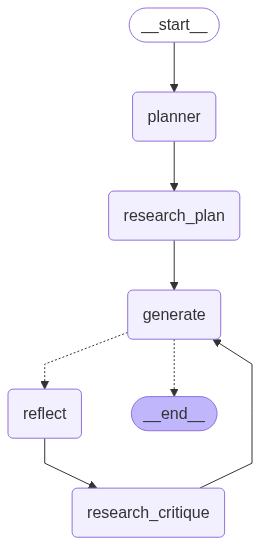

In [24]:
Image(graph.get_graph().draw_mermaid_png())

### Run the agent - write on!

Now it's time to run our essay writing agent. We'll provide an initial essay topic and configuration, then stream the agent's execution to observe each step and its output.

In [ ]:
# Define the topic of the essay
ESSAY_TOPIC = (
    "What were the impacts of Hurricane Helene and Hurricane Milton in 2024?"
)

# Define a thread configuration with a unique thread ID
thread = {"configurable": {"thread_id": "1"}}

# Stream through the graph execution with an initial task and state
for s in graph.stream(
    {
        "task": ESSAY_TOPIC,  # Initial task
        "max_revisions": 2,  # Maximum number of revisions allowed
        "revision_number": 1,  # Current revision number
        "content": [],  # Initial empty content list
    },
    thread,
):
    step = next(iter(s))
    display(Markdown(f"# {step}"))
    for key, content in s[step].items():
        if key == "revision_number":
            display(Markdown(f"**Revision Number**: {content}"))
        elif isinstance(content, list):
            for c in content:
                display(Markdown(c))
        else:
            display(Markdown(content))
    print("\n---\n")

### Dive Deeper into LangGraph
Ready to explore further? The official LangGraph documentation is an excellent resource:

* [Core Concepts](https://langchain-ai.github.io/langgraph/): For a refresher on the foundational elements like State, Nodes, and Edges.
* [Tutorials](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/): See LangGraph in action with a variety of examples.

Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.